# Krypton RPHI Lifetime

## Produce RPHI lifetime maps

### Authors: GML, JAH, JJGC

### Software KrCalib : https://github.com/nextic/KrCalib/

In [2]:
%load_ext autoreload
%autoreload 2
import os
import time
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri Aug 31 16:00:52 2018


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = ' '
map_file_name     = 'kr_maps_rphi_6206.h5'
map_file_name_ts  = 'kr_maps_rphi_ts_6206.h5'
emap_file_name    = ' '



krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [10]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event
from krcal.core.analysis_functions      import event_map

In [11]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [12]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [13]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName
from krcal.core          import fit_functions_ic as fitf

In [14]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_alpha_map
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import draw_xy_maps
from krcal.core.map_functions   import draw_xy_map
from krcal.core.map_functions   import draw_map
from krcal.core.map_functions   import draw_xy_maps_ts

In [15]:
import krcal.dev.corrections       as corrections 


In [16]:
from numpy import pi, sqrt

In [17]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [18]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [19]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [20]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10000_19999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_20000_29999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_6206.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_ts_6206.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ')

In [21]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [22]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [23]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [24]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [25]:
RMAX      = 200
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-RMAX,  RMAX)
z_range   = (50,  550)
e_range = (5000, 14000)
lt_range = (1000, 5000)
c2_range = (0,3)

NSECTORS =20
SPHI     =10


krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [26]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

### Time 

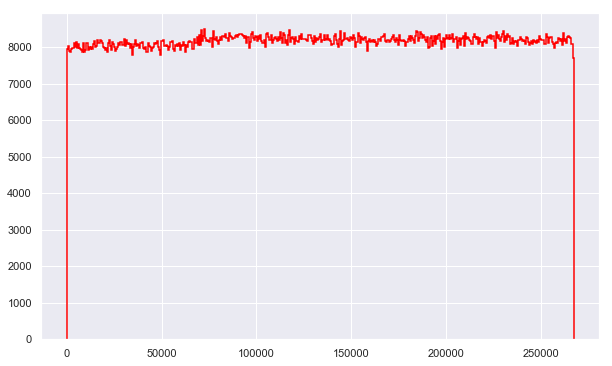

In [27]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

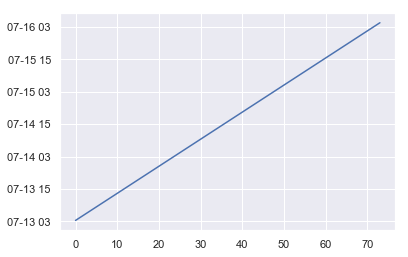

In [28]:
plt.plot(krTimes.timeStamps)

## Divide chamber in 20 sector of R and 36 sectors of Phi

In [29]:
#R, PHI = rphi_sector_alpha_map(rmin  =  20,
#                               rmax  = 180,
#                               alpha =  0.5,
#                               sphi  = 5)

In [30]:
R, PHI = rphi_sector_map(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [31]:
W = define_rphi_sectors(R, PHI, verbose=False)
nSectors = len(R.keys())
print(f'nSectors = {nSectors}')

nSectors = 20


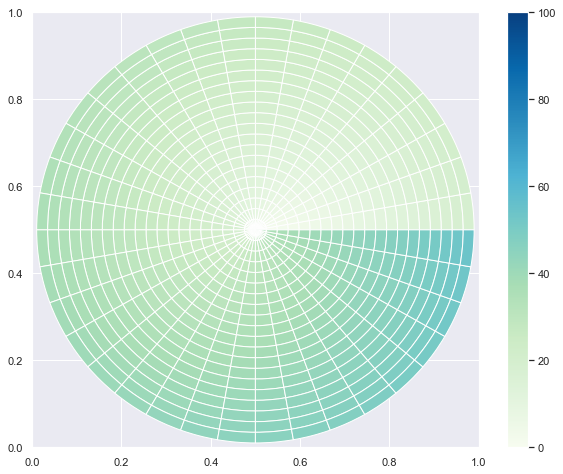

In [32]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(nSectors))

### Colors in the above plot are just intended to "guide the eye". The map shows the partition of the chamber in sectors of R-Phi

In [33]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W, verbose = False)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 54.17564797401428


### Event distribution

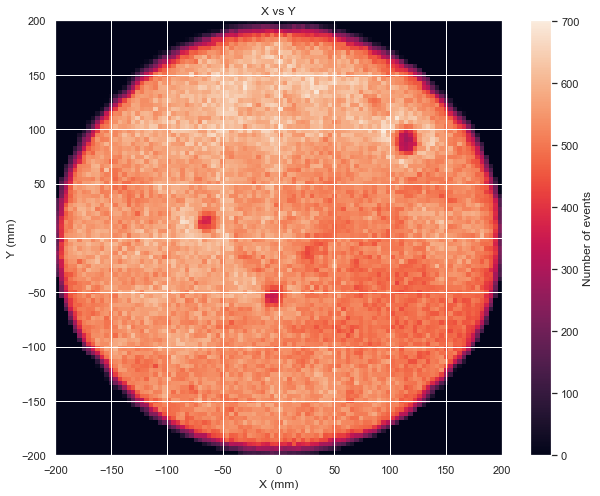

In [34]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 11025.0


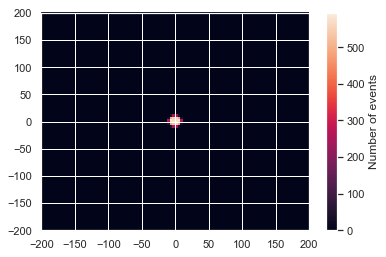

In [35]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=0)

number of events in sector = 11025.0
number of events in sector = 32722.0
number of events in sector = 53529.0
number of events in sector = 72935.0
number of events in sector = 95979.0
number of events in sector = 117129.0
number of events in sector = 138223.0
number of events in sector = 161519.0
number of events in sector = 182879.0
number of events in sector = 204093.0
number of events in sector = 226607.0
number of events in sector = 250645.0
number of events in sector = 273116.0
number of events in sector = 296224.0
number of events in sector = 316598.0
number of events in sector = 336838.0
number of events in sector = 357853.0
number of events in sector = 372835.0
number of events in sector = 363720.0
number of events in sector = 211720.0


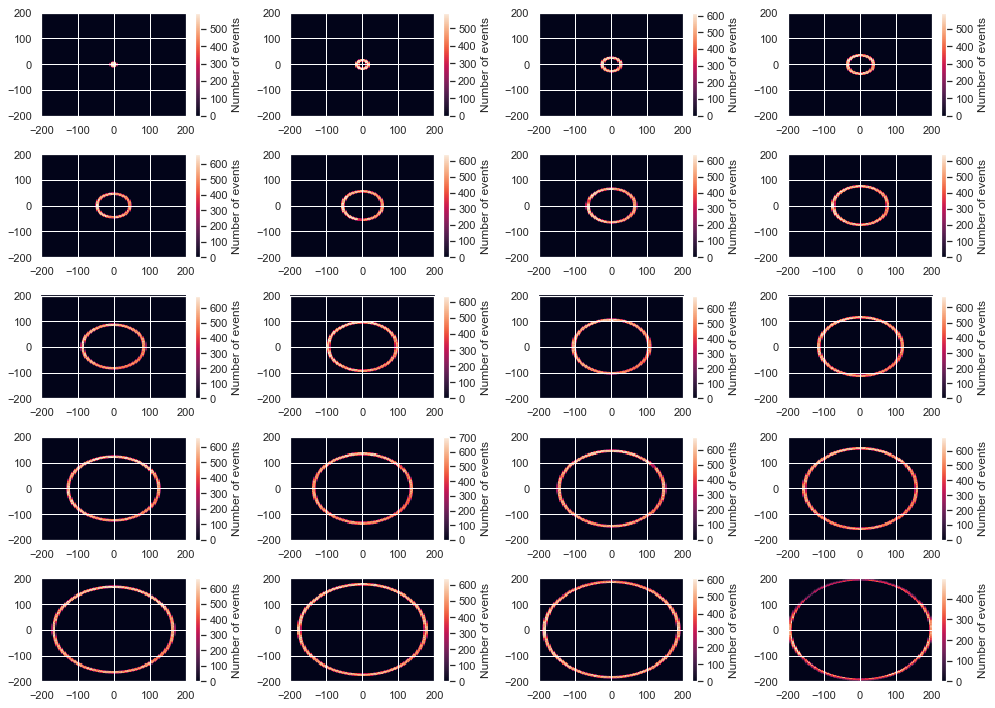

In [36]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, nx = 5, ny =4,figsize=(14,10))

In [37]:
neM = event_map(KRES)

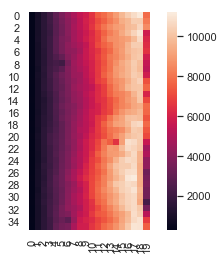

In [38]:
ax = sns.heatmap(neM, square=True)

##### The heat map illustrates the problem of using R-phi symmetry. As the sectors becomes smaller (near the center of the detector), the number of events per sector/wedge also becomes small. Using a XY symmetry avoids this problem, but does not follow the chamber symmetry.

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [39]:
DT[-1] /50000

5.348874159998894

In [40]:
XT = 50000

#### For example, fits to various sectors (20 sectors in R) and wedges (36 sectors in Phi) follow

In [41]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z = z_range, 
                         range_e = e_range,
                         energy  = 'S2e', 
                         fit = FitType.profile)
                    

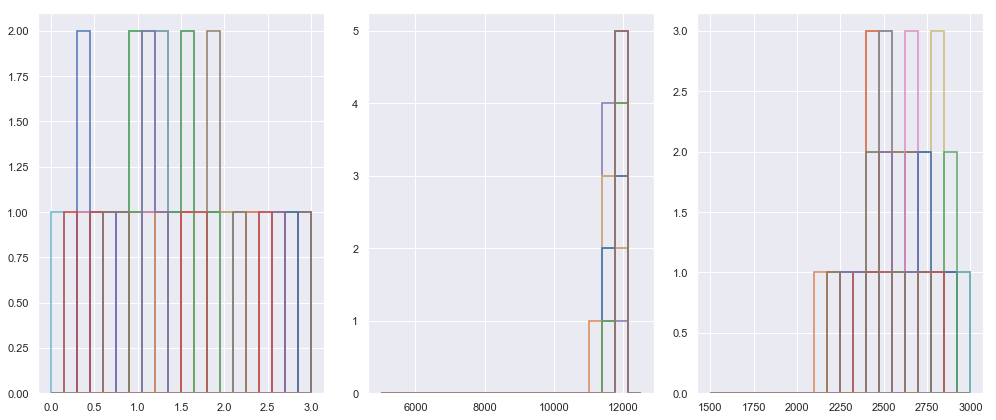

In [42]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1500, 3000))
#print_fit_sectors_pars(fpts)

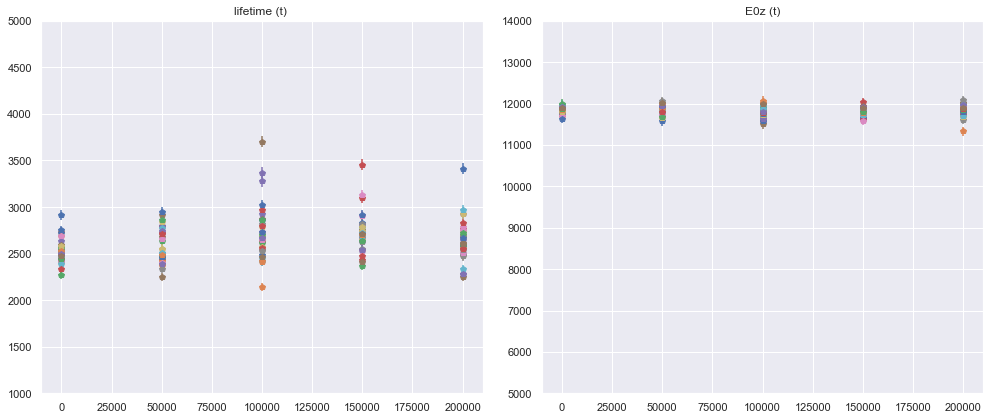

In [43]:
plot_fit_sectors(fps,  range_e0 =e_range, range_lt=lt_range)

In [44]:
fps = fit_fcs_in_sectors(5, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z = z_range, 
                         range_e = e_range,
                         energy  = 'S2e', 
                         fit = FitType.profile)
 

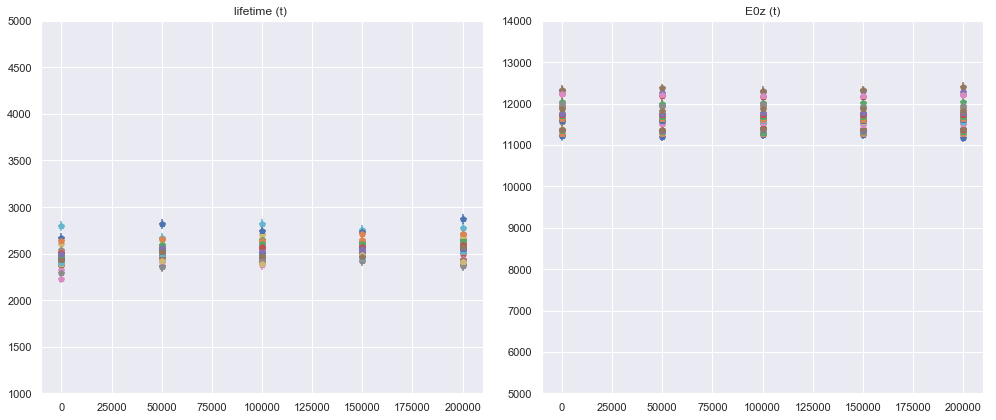

In [45]:
plot_fit_sectors(fps,  range_e0 =e_range, range_lt=lt_range)

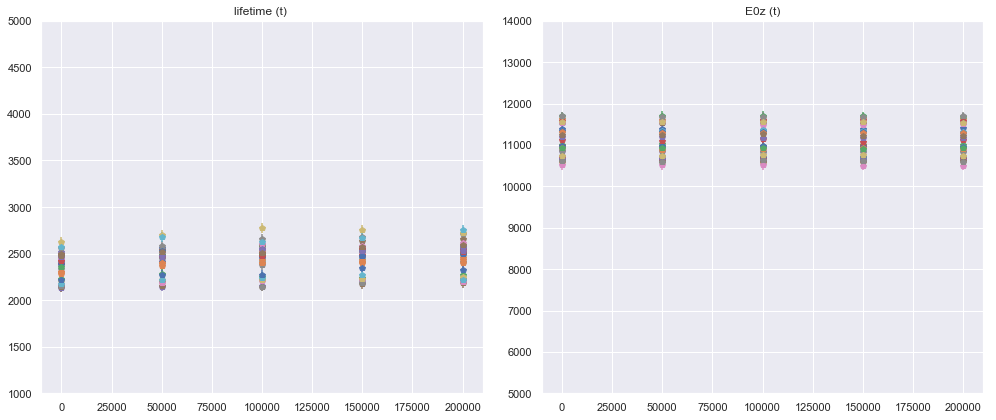

In [46]:
fps = fit_fcs_in_sectors(10, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z = z_range, 
                         range_e = e_range,
                         energy  = 'S2e', 
                         fit = FitType.profile)

plot_fit_sectors(fps,  range_e0 =e_range, range_lt=lt_range)


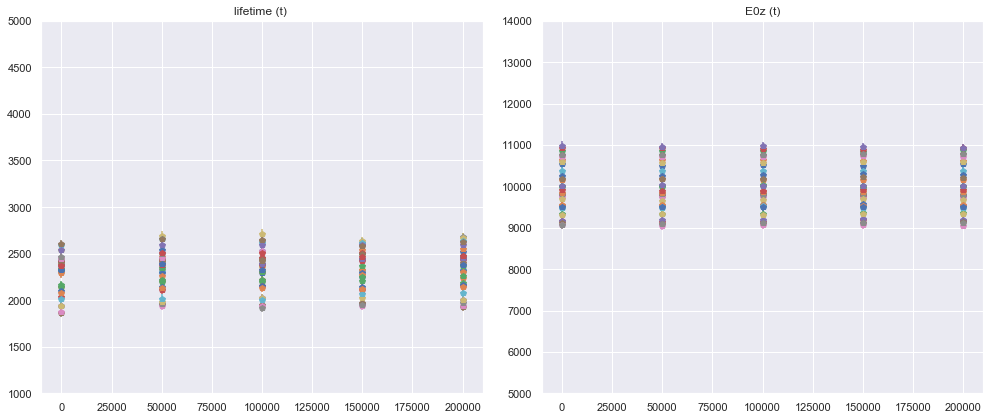

In [47]:
fps = fit_fcs_in_sectors(15, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z = z_range, 
                         range_e = e_range,
                         energy  = 'S2e', 
                         fit = FitType.profile)

plot_fit_sectors(fps,  range_e0 =e_range, range_lt=lt_range)



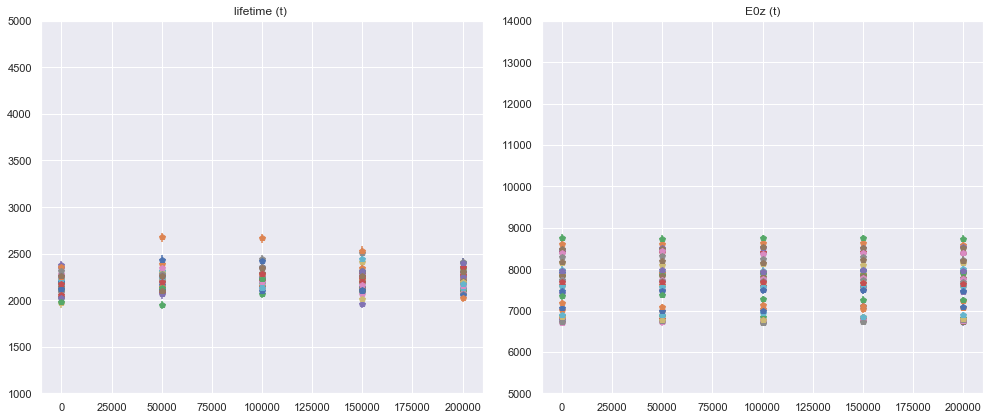

In [48]:
fps = fit_fcs_in_sectors(19, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z = z_range, 
                         range_e = e_range,
                         energy  = 'S2e', 
                         fit = FitType.profile)

plot_fit_sectors(fps,  range_e0 =e_range, range_lt=lt_range)



#### Notice that e0 c0nstants become more spread at large R. This implies that a second correction will be needed.

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```
Thus, for each radial sector (0, 1, 2...) the function returns a list of objects, one object per phi sector (or wedge). Each object contains 6 time series; ts is time (time difference wrt to the start of the run); e0, lt... are fitted parameters to time slices.

In [49]:
t0 = time.time()
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = z_range,
               range_e     = e_range,
               range_chi2  = c2_range,
               range_lt    = lt_range,
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = False)
t1 = time.time()
print(f' fmap: t = {t1 -t0}')

 fmap: t = 8.8838050365448


##### This fit is much faster (by a factor 30) than the dense XY fit. On the other hand the procedure needs a second correction (geometry), which is not necessary for XY maps (where the XY fit is done if small bins and thus no further readjustment is needed)

In [50]:
ts = fmap[0][0].ts

In [51]:
ts

array([     0,  50000, 100000, 150000, 200000])

In [52]:
DT

array([0.00000000e+00, 2.16000080e-01, 2.30000019e-01, ...,
       2.67443503e+05, 2.67443696e+05, 2.67443708e+05])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [53]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

<ErrorbarContainer object of 3 artists>

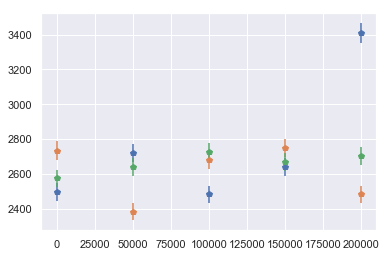

In [54]:
plt.errorbar(ts, tsm.lt[0][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[0][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[0][2], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

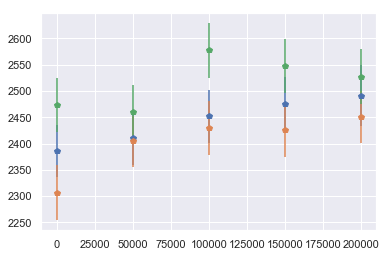

In [55]:
plt.errorbar(ts, tsm.lt[10][10], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[10][11], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[10][12], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

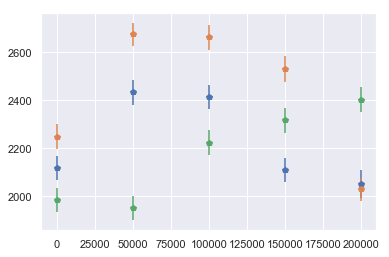

In [56]:
plt.errorbar(ts, tsm.lt[19][30], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[19][31], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[19][32], np.sqrt(tsm.lt[0][2]), fmt="p")

#### Obtain ampa from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : Dict[int, List[float]]
    e0    : Dict[int, List[float]]
    lt    : Dict[int, List[float]]
    e0u   : Dict[int, List[float]]
    ltu   : Dict[int, List[float]]
```
In this ASectorMap each wege contains a single number, and thus ASectorMap is really a 
collection of 5 maps. 

#### Example: map in the first time series

In [57]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [58]:
amap_average(am) 

ASectorMap(chi2=1.1890785231085799, e0=10723.134463379933, lt=2370.275876771903, e0u=19.481076529940022, ltu=35.045682813724255)

#### Get rid of outlayers that distort mean and error

In [59]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range, debug=True)

 set nans to average value of interval = 9500.0
 set nans to average value of interval = 3000.0


##### Unlike the XY fits, the fits in RPhi tend to show few outlayers.

In [60]:
asm = relative_errors(rmap)

In [61]:
amap_average(asm)

ASectorMap(chi2=1.1890785231085799, e0=10723.134463379933, lt=2370.275876771903, e0u=0.18166636356105897, ltu=1.4622881270660621)

##### The average errors are also smaller than for XY maps (more events). This suggest that the procedure of fitting in larger XY bins and then re-correcting by energy map (as originally done by Gonzalo) may make sense. 

#### Draw the maps using default colormap

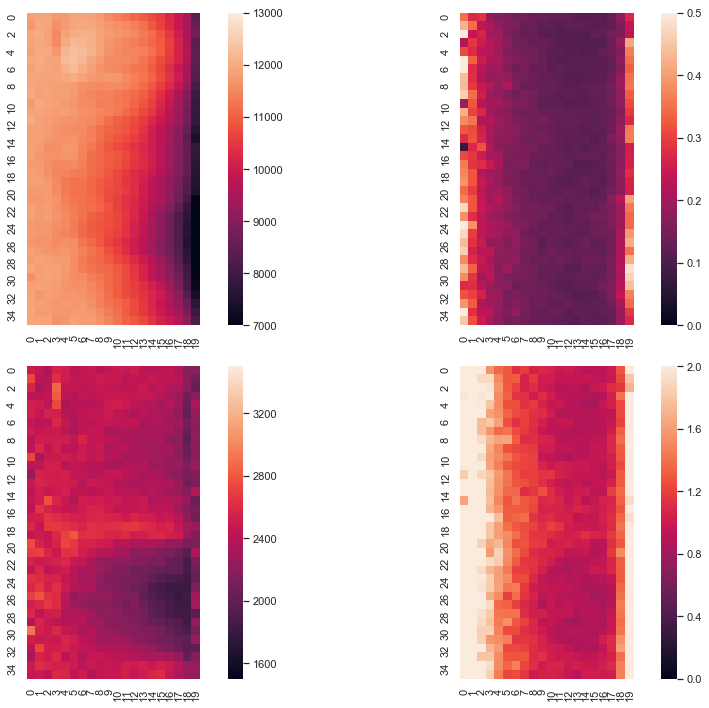

In [62]:
draw_xy_maps(asm,
            e0lims  = (7000, 13000),
            ltlims  = (1500, 3500),
            eulims  = (0.0,  0.5),
            lulims  = (0, 2),
            figsize=(14,10))

##### Above drawings are heat maps, which map very well the chamber in the case of XY bins (teselation). For RPHI bins the symmetry is not the right one, but we can use RPHI maps.

#### In covergent colors (from dark to light)

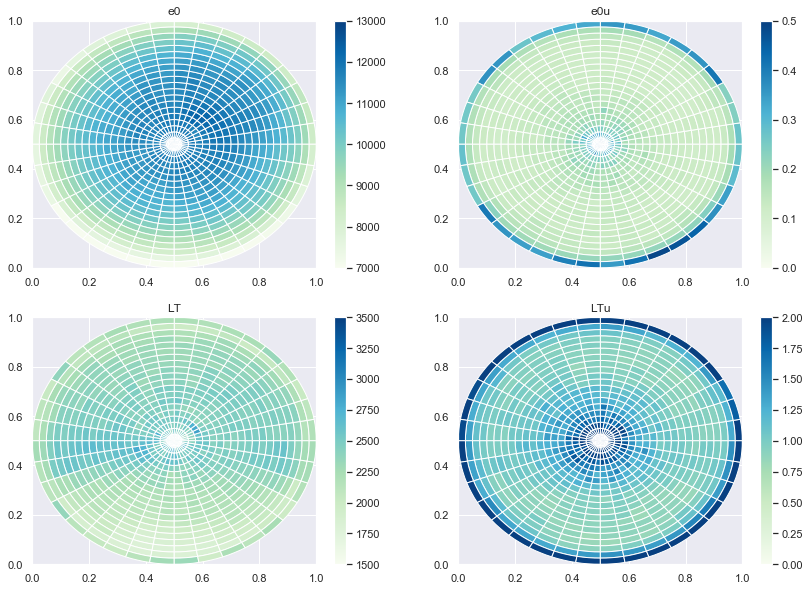

In [63]:
draw_maps(W, asm,  
          e0lims  = (7000, 13000),
          ltlims  = (1500, 3500),
          eulims  = (0, 0.5),
          lulims  = (0,2),
          cmap    = matplotlib.cm.GnBu, 
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

#### Seaborn default: divergent colors (from light to dark)

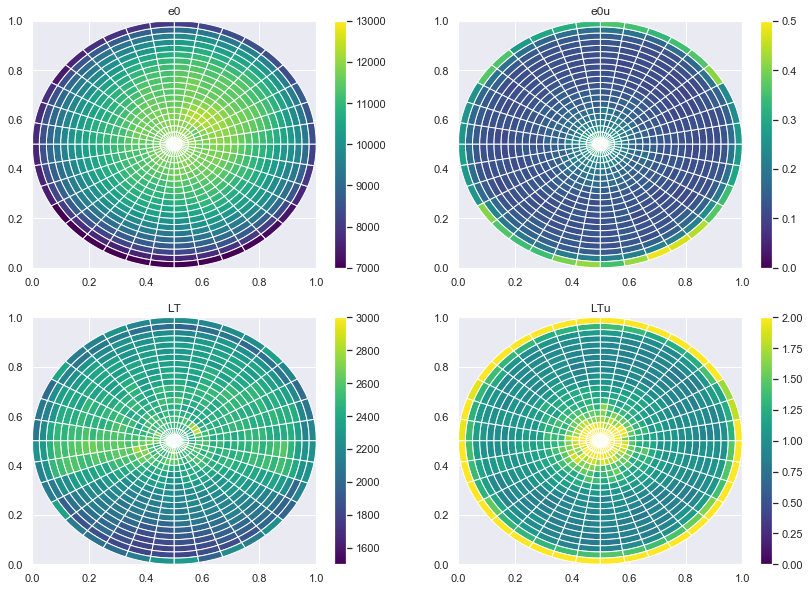

In [64]:
draw_maps(W, asm,  
          e0lims  = (7000, 13000),
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = (0,2),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

## Compute the average of maps

#### Get all amaps (for each time interval). Maps returned are regularized and errors relative.

In [65]:
times = ts

In [66]:
amaps = get_maps_from_tsmap(tsm, 
                            times   = times, 
                            erange  = e_range,
                            ltrange = lt_range,
                            c2range = c2_range)

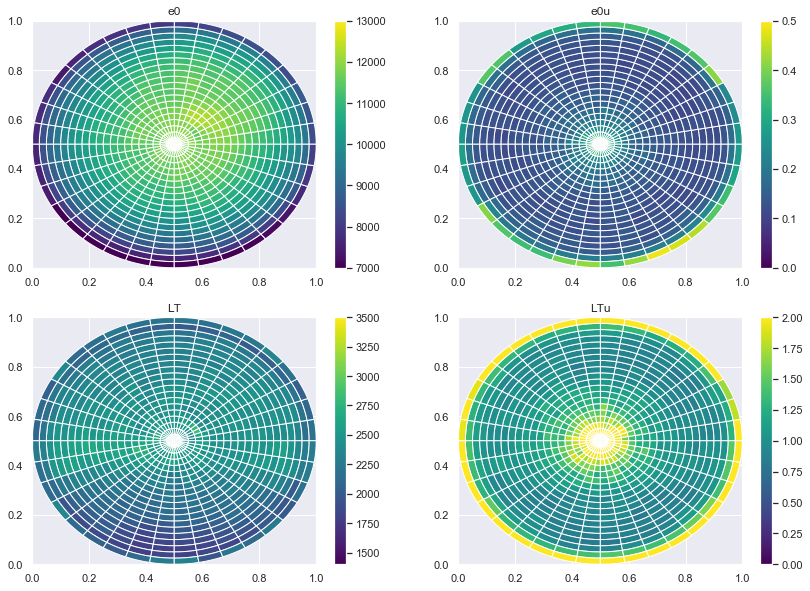

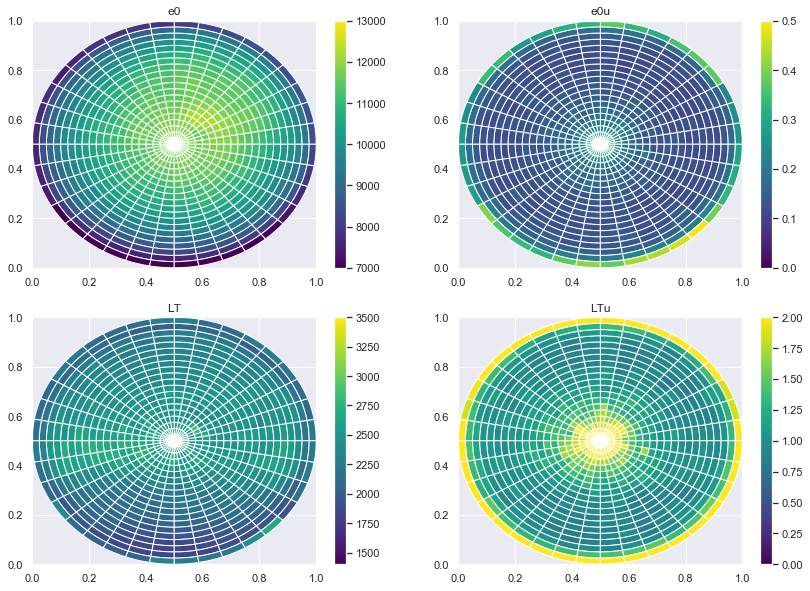

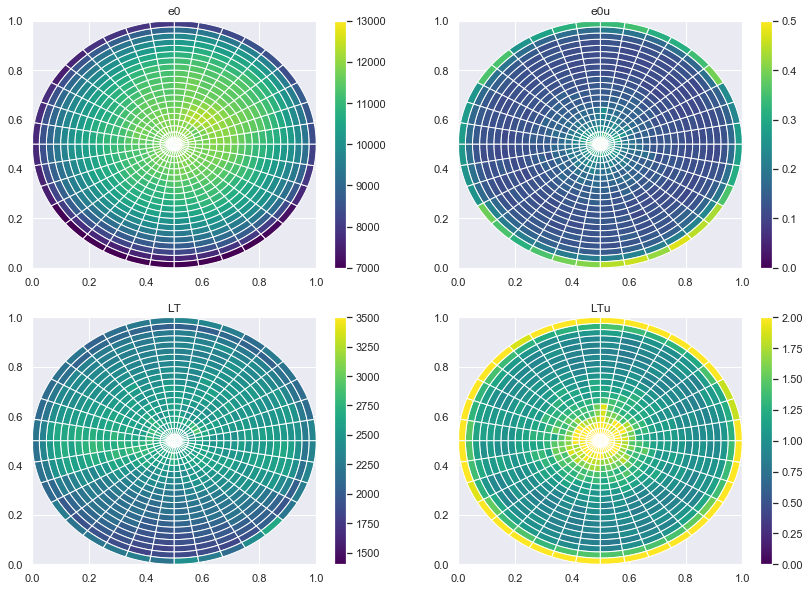

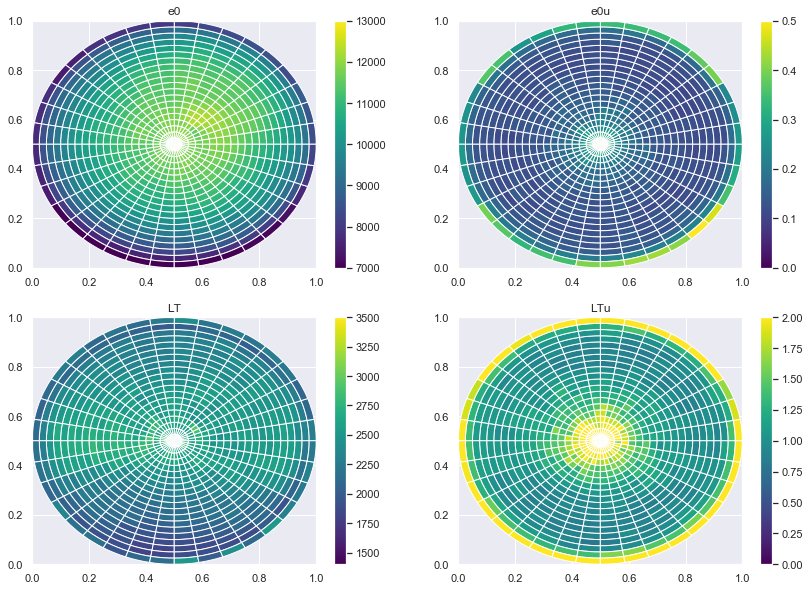

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-07-28/lib/python3.7/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


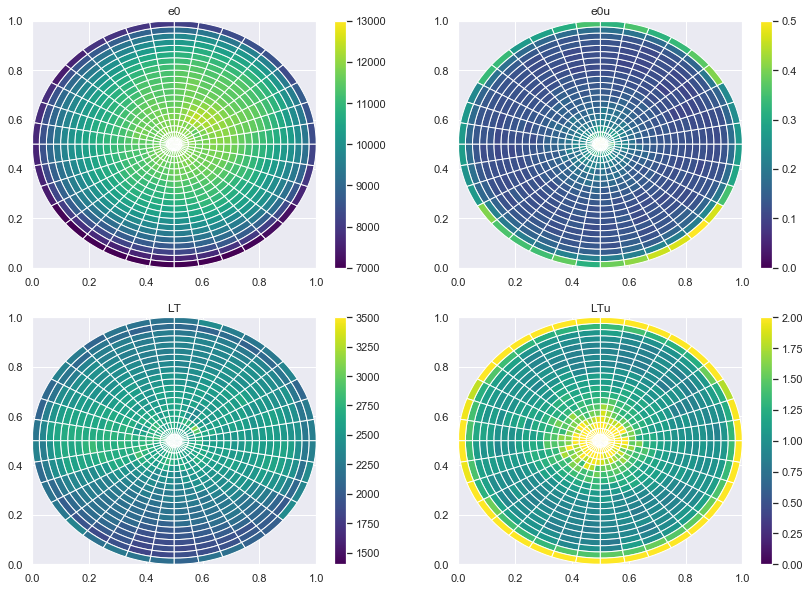

In [67]:
for amap in amaps:
    draw_maps(W, amap,  
          e0lims  = (7000, 13000),
          ltlims  = (1400, 3500),
          eulims  = (0, 0.5),
          lulims  = (0,2),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))


#### Compute the average map

In [68]:
amAV = map_average(amaps)

#### And draw it

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-07-28/lib/python3.7/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


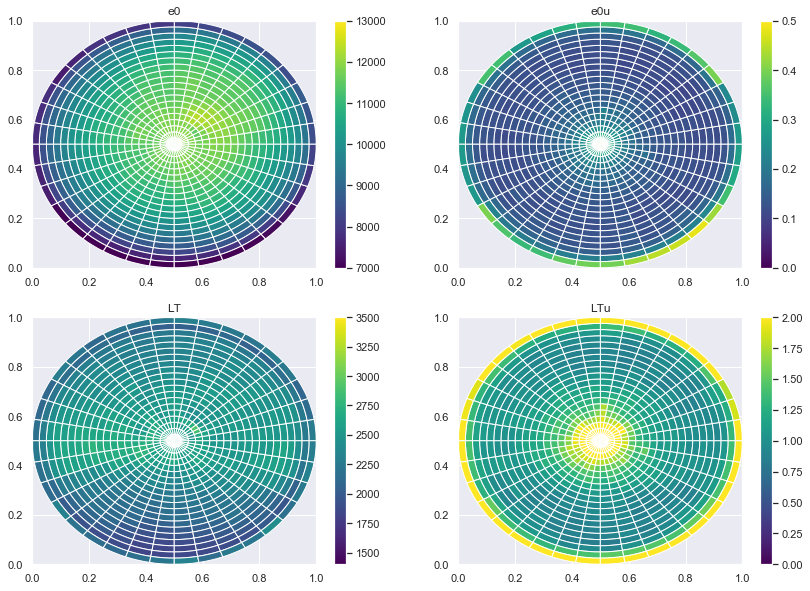

In [69]:
draw_maps(W, amAV,  
          e0lims  = (7000, 13000),
          ltlims  = (1400, 3500),
          eulims  = (0, 0.5),
          lulims  = (0,2),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

#### Compute the averages of the map

In [70]:
amv = amap_average(amAV) 

In [71]:
amv

ASectorMap(chi2=1.2283356999186106, e0=10717.948395678455, lt=2429.431977366945, e0u=0.18220520773353344, ltu=1.4991243804957883)

##### In the case of XY maps one needs to replace NANs by the average. This should not be the case for RPHI map, but the procedure works nevertheless.

In [72]:
amAV0 = amap_replace_nan_by_mean(amAV, amMean=amv)

In [73]:
amap_average(amAV0) 

ASectorMap(chi2=1.2283356999186106, e0=10717.948395678455, lt=2429.1416780666323, e0u=0.18220520773353344, ltu=1.4962666736424197)

##### We can see that the means are identical. The map has no nans 

#### The map that averages the time series can also be obtained by setting ts = -1 

In [74]:
amAvts = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1400, 3500))

In [75]:
asmAvTs = relative_errors(amAvts)

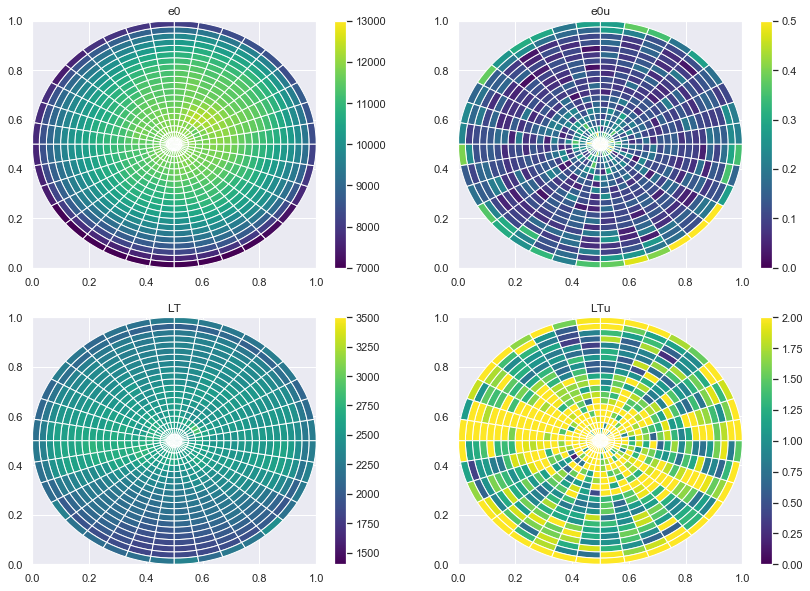

In [76]:
draw_maps(W, asmAvTs,  
          e0lims  = (7000, 13000),
          ltlims  = (1400, 3500),
          eulims  = (0, 0.5),
          lulims  = (0,2),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

In [77]:
amap_average(asmAvTs)

ASectorMap(chi2=1.1740840363615725, e0=10717.948395678455, lt=2428.9667326461117, e0u=0.18254824153548804, ltu=2.081226971245857)

#### The e0 and LT maps are identical using one or the other procedures, but the estimation of errors is different (should be more accurate by averaging data frames)

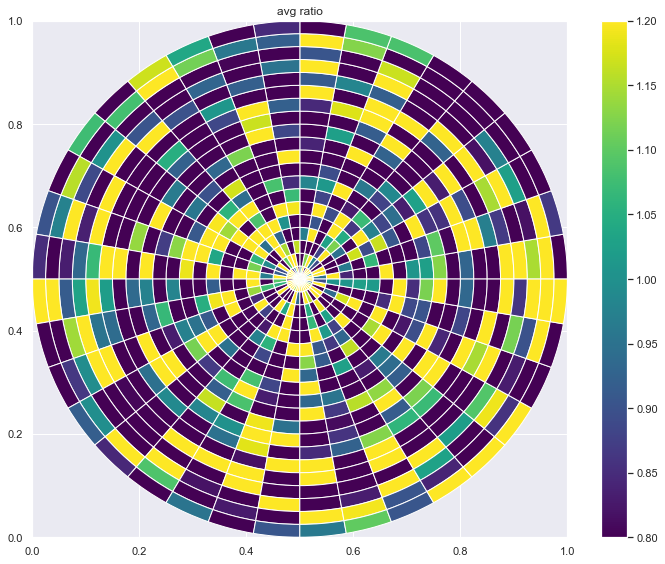

In [79]:
draw_map(W, asmAvTs.e0u / amAV0.e0u,  
        alims   = (0.8, 1.2),
        title   = 'avg ratio',
        rmax=RMAX, 
        scale=0.5,
        alpha   = 1.0,  
        figsize=(10,8))

#### The maps can be saved to file

In [80]:
write_maps(amAV0, filename=fn.map_file_name)

#### And retrieved from file

In [81]:
amap2 = read_maps(filename=fn.map_file_name)

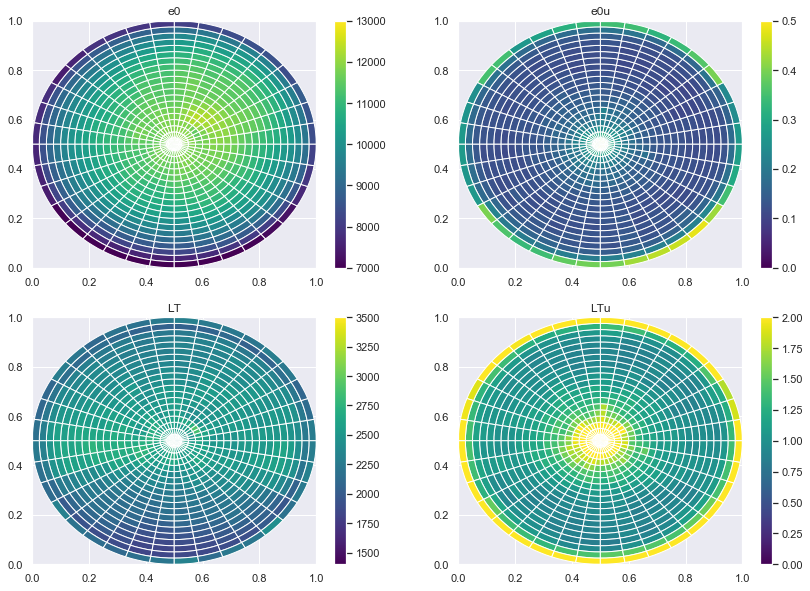

In [82]:
draw_maps(W, amap2,  
          e0lims  = (7000, 13000),
          ltlims  = (1400, 3500),
          eulims  = (0, 0.5),
          lulims  = (0,2),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

#### To write the complete time-series of maps
```
write_maps_ts(aMaps : Iterable[ASectorMap], ts: np.array, filename : str)
```

In [83]:
aMaps = []
for amap in amaps:
    amv = amap_average(amap) 
    aMaps.append(amap_replace_nan_by_mean(amap, amv))

In [84]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)